In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import numpy as np
from numpy.random import seed
import tensorflow as tf

from tensorflow import set_random_seed
seed(42)
set_random_seed(42)



from keras.layers import Input, Dense, TimeDistributed, Embedding
from keras.layers import Concatenate, Reshape, Lambda, Multiply, multiply, concatenate
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib import style

from dataset_load import *

style.use('seaborn-whitegrid')

def open_pickle(path):
    import pickle
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

def load_unigrams(path, X, y):
    word_list = []
    connotation = {}
    
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            word_list.append(line.strip())
            
    for word in word_list:
        pos_count = 0
        neg_count = 0
        for i, doc in enumerate(X):
            if word in doc.lower():
                
                if (y[i] == 1):
                    pos_count += 1
                else:
                    neg_count += 1
                    
        if pos_count > neg_count:
            connotation[word] = 1
        else:
            connotation[word] = 0
    
    return word_list, connotation

def generate_appearance(X_train_corpus, X_test_corpus, word_list, connotation):
    y_train_agreement = []
    for i in range(len(X_train_corpus)):
        doc_agreement = []
        for word in word_list:
            if word in X_train_corpus[i]:
                if connotation[word] == 1:
                    doc_agreement.append(1)
                else:
                    doc_agreement.append(-1)
            else:
                doc_agreement.append(0)
        y_train_agreement.append(doc_agreement)
        
    y_test_agreement = []
    for i in range(len(X_test_corpus)):
        doc_agreement = []
        for word in word_list:
            if word in X_test_corpus[i]:
                if connotation[word] == 1:
                    doc_agreement.append(1)
                else:
                    doc_agreement.append(-1)
            else:
                doc_agreement.append(0)
        y_test_agreement.append(doc_agreement)
        
    return np.array(y_train_agreement), np.array(y_test_agreement)

# 'imdb-unigrams.txt'
path = r"../../data/reviews_Amazon_Instant_Video_5.json.gz"

X, y = extract_review_amazon(path, 'reviewText')
y_label = np.asarray(y)

neutral_indices = np.where(y_label == 3)[0]
y_label[y_label<3] = 0
y_label[y_label>3] = 1

X_discarded = np.delete(X,neutral_indices)
y_discarded = np.delete(y_label, neutral_indices)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit

# split
X_train_split, X_test_split, y_train, y_test = train_test_split(X_discarded, y_discarded, test_size=0.33, random_state=42)

# preprocessing
X_train_corpus_update = update_corpus_contraction(X_train_split)
X_test_corpus_update = update_corpus_contraction(X_test_split)

# Count vectorizer 

# count vectorizer
token = r"(?u)\b[\w\'/]+\b"
cv = CountVectorizer(lowercase=True, max_df=1.0, min_df=100, binary=True, token_pattern=token)
cv.set_params(ngram_range=(1,1))

cv.fit(X_train_split)

X_train = cv.transform(X_train_corpus_update)
X_test = cv.transform(X_test_corpus_update)

words = cv.get_feature_names()


word_list, connotation = load_unigrams('./amazon-video-unigrams-more.txt', X_train_corpus_update, y_train)
# word_list, connotation = load_unigrams('./imdb-unigrams.txt', X_train_corpus_update, y_train)
# word_list, connotation = load_unigrams('./ecom-unigrams.txt', X_train_corpus_update, y_train)

y_train_agreement, y_test_agreement = generate_appearance(X_train_corpus_update, X_test_corpus_update, 
                                                          word_list, connotation)

def history_plot(history, model_name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
        
    title = model_name + 'accuracy'
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend(['tr_acc', 'val_acc'], loc='upper left')
    plt.show()
    plt.clf()

    plt.plot(history.history['loss'], 'm--')
    plt.plot(history.history['val_loss'], 'y--')

    title = model_name + 'loss'
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend(['tr_loss', 'val_loss'], loc='upper left')
    plt.show()
    plt.clf()

Using TensorFlow backend.


(75, 2)
corpus update start
corpus update end

(75, 2)
corpus update start
corpus update end



In [3]:
np.unique(y_train_agreement)

array([-1,  0,  1])

In [2]:
y_train_agreement_LR = np.copy(y_train_agreement)
y_train_agreement_LR[y_train_agreement_LR != 0] = 1

y_test_agreement_LR = np.copy(y_test_agreement)
y_test_agreement_LR[y_test_agreement_LR != 0] = 1

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1', random_state=42)

clf.fit(y_train_agreement_LR, y_train)

print(clf.score(y_train_agreement_LR, y_train))
print(clf.score(y_test_agreement_LR, y_test))

0.9096470161765372
0.9108555657773689


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Test the custom loss

In [2]:
# # https://stackoverflow.com/questions/48951109/keras-custom-binary-cross-entropy-loss-function-get-nan-as-output-for-loss

# def custom_cross_entropy(y_true, y_pred):
#     t_loss = K.max(y_pred,0)-y_pred * y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))
#     return K.mean(t_loss)

# from keras.initializers import Constant, glorot_uniform

# input_layer = Input(shape=(X_train.shape[1],))
# tanh_output = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(input_layer)
# model = Model(inputs=input_layer, outputs=tanh_output)

# model.compile(loss=custom_cross_entropy,
#              metrics=['acc'],
#              optimizer='adam')

# model.fit(X_train[:16667], y_train_original[:16667], 
#          validation_data=([X_train[16667:], y_train_original[16667:]]),
#          batch_size=1, epochs=1)

In [3]:
# model.evaluate(X_test, y_test_original)

In [4]:
# model.evaluate(X_train, y_train_original)

### 1st model

In [4]:
from keras.initializers import Constant, glorot_uniform

input_layer = Input(shape=(X_train.shape[1],))
tanh_output = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(input_layer)
model = Model(inputs=input_layer, outputs=tanh_output)

model.compile(loss='binary_crossentropy',
             metrics=['acc'],
             optimizer='adam')

base_history = model.fit(X_train, y_train, 
                 validation_split=0.33, shuffle=False,
                 batch_size=1, epochs=1)

Train on 14786 samples, validate on 7283 samples
Epoch 1/1
14786/14786 [==============================] - 43s 3ms/step - loss: 0.2538 - acc: 0.9057 - val_loss: 0.2038 - val_acc: 0.9241


In [6]:
# model.evaluate(X_test, y_test_original)

In [7]:
# model.evaluate(X_train, y_train_original)

In [8]:
model.trainable=True

### 2nd model

In [5]:
def layer_split(x):
    return tf.split(x,num_or_size_splits=human_terms_len,axis=1)

def layer_concat(x):
    return tf.concat(x, axis=1)

# build the combined model
# Combined model
human_terms_len = len(word_list)

# base_model = build_base_model(X_train.shape[1])

combined_input_layer = Input(shape=(X_train.shape[1],))

# build the hard coded weight for human terms
ht_input_layer = Input(shape=(human_terms_len,))

# split = Lambda( lambda x: tf.split(x,num_or_size_splits=human_terms_len,axis=1))(ht_input_layer)
split = Lambda(layer_split)(ht_input_layer)

# get the document prediction
label_layer = model(combined_input_layer)
tanh_norm = Lambda(lambda x: (x*2)-1)(label_layer)
# tanh_norm = Lambda(lambda x: tf.scalar_mul(2,x)-1)(label_layer)

# do normalize of bipolar sigmoid


# stack the multiply layer
dense_layer = []
for i in range(human_terms_len):
    dense_layer.append(Dense(1, activation='relu', use_bias=False)(Multiply()([split[i], tanh_norm])))

# concat all the result   
# concat = Lambda( lambda x: tf.concat(x, axis=1), name='concatenate')(dense_layer)
concat = Lambda(layer_concat, name='concatenate')(dense_layer)


# pass it to sigmoid layer
output_layer = Dense(1, activation='sigmoid')(concat)

combined_model = Model(inputs=[combined_input_layer, ht_input_layer], outputs=output_layer)
# combined_model.summary()


combined_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

# y_train_tanh = y_train_original
# y_train_tanh[y_train_tanh == 0] = -1

# y_test_tanh = y_test_original
# y_test_tanh[y_test_tanh == 0] = -1

# base_model_history = base_model.fit(X_train[:16667], y_train_original[:16667], 
#                                     validation_data=(X_train[16667:], y_train_original[16667:]),
#                                     batch_size=1, epochs=1)

combined_model_history = combined_model.fit([X_train,y_train_agreement], y_train, 
                                            validation_split=0.33, shuffle=False,
                                            batch_size=1, epochs=1)

Train on 14786 samples, validate on 7283 samples
Epoch 1/1
14786/14786 [==============================] - 170s 11ms/step - loss: 0.3213 - acc: 0.8898 - val_loss: 0.2845 - val_acc: 0.9010


In [6]:
def accuracy_reject(combined_model, X, y_agreement, y):
    human_terms_relu_model = Model(inputs=combined_model.input,
                                    outputs=combined_model.get_layer('concatenate').output)
    predict_relu = human_terms_relu_model.predict([X, y_agreement])
    accept_indices = np.where(np.sum(predict_relu, axis=1)!=0)
    accept_indices = accept_indices[0]
    total_reject = X.shape[0] - len(accept_indices)
    rejection_rate = total_reject/X.shape[0]

    test_eval = combined_model.evaluate([X[accept_indices], y_agreement[accept_indices]], y[accept_indices])
    
    return test_eval, rejection_rate, total_reject

In [7]:
test_ev = combined_model.evaluate([X_test, y_test_agreement], y_test)
train_ev = combined_model.evaluate([X_train, y_train_agreement], y_train)

def accuracy_reject(combined_model, X, y_agreement, y):
    human_terms_relu_model = Model(inputs=combined_model.input,
                                    outputs=combined_model.get_layer('concatenate').output)
    predict_relu = human_terms_relu_model.predict([X, y_agreement])
    accept_indices = np.where(np.sum(predict_relu, axis=1)!=0)
    accept_indices = accept_indices[0]
    total_reject = X.shape[0] - len(accept_indices)
    rejection_rate = total_reject/X.shape[0]

    test_eval = combined_model.evaluate([X[accept_indices], y_agreement[accept_indices]], y[accept_indices])
    
    return test_eval, rejection_rate, total_reject

test_ev_reject = accuracy_reject(combined_model, X_test, y_test_agreement, y_test)
train_ev_reject = accuracy_reject(combined_model, X_train, y_train_agreement, y_train)

11868/11868 [==============================] - 1s 112us/step


In [8]:
np.unique(y_test_agreement)

array([-1,  0,  1])

In [9]:
test_ev_reject

([0.2309970182156064, 0.909477624658705], 0.4593376264949402, 4993)

In [10]:
print('%f \t %f' %(train_ev[0], train_ev[1]))
print('%f \t %f' %(test_ev[0], test_ev[1]))
print('%f \t %f \t %f \t %d' %(train_ev_reject[0][0], train_ev_reject[0][1], train_ev_reject[1], train_ev_reject[2]))
print('%f \t %f \t %f \t %d' %(test_ev_reject[0][0], test_ev_reject[0][1], test_ev_reject[1], test_ev_reject[2]))

0.269411 	 0.902578
0.278157 	 0.904784
0.202960 	 0.911611 	 0.462232 	 10201
0.230997 	 0.909478 	 0.459338 	 4993


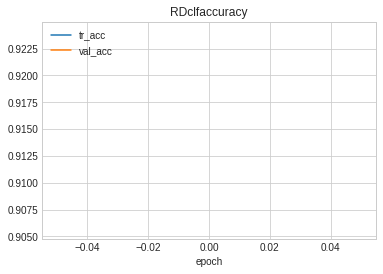

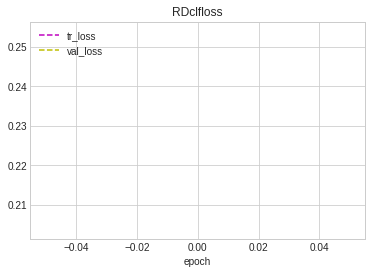

<Figure size 432x288 with 0 Axes>

In [11]:
history_plot(base_history,'RDclf')

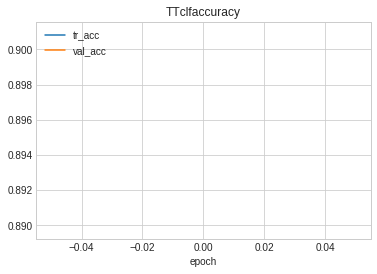

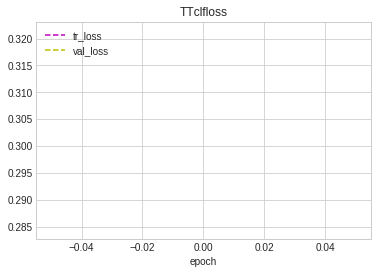

<Figure size 432x288 with 0 Axes>

In [12]:
history_plot(combined_model_history,'TTclf')

In [13]:
# combined_model.save('./figure/amazon-trainable-1-50.h5')

### Other experiment

## LR1-KEY

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

ht_lr = LogisticRegression(penalty='l1', random_state=42)


# Train LR
ht_lr.fit(y_train_agreement_LR, y_train)
ht_test_pred = ht_lr.predict(y_test_agreement_LR)

human_terms_relu_model = Model(inputs=combined_model.input,
                                    outputs=combined_model.get_layer('concatenate').output)
predict_relu = human_terms_relu_model.predict([X_test, y_test_agreement])
accept_indices = np.where(np.sum(predict_relu, axis=1)!=0)
accept_indices = accept_indices[0]
total_reject = X_test.shape[0] - len(accept_indices)
rejection_rate = total_reject/X_test.shape[0]

test_eval = combined_model.evaluate([X_test[accept_indices], y_test_agreement[accept_indices]], y_test[accept_indices])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5877/5877 [==============================] - 1s 111us/step


In [16]:
len(word_list)

78

In [17]:
lr1_accept_indices = np.where(np.sum(y_test_agreement_LR, axis=1)!=0)[0]

ht_lr.score(y_test_agreement_LR, y_test), ht_lr.score(y_test_agreement_LR[lr1_accept_indices], y_test[lr1_accept_indices])

(0.9108555657773689, 0.920536756126021)

In [18]:
our_reject_indices = np.where(np.sum(predict_relu, axis=1)==0)[0]

lr1_reject_indices = np.where(np.sum(y_test_agreement_LR, axis=1)==0)[0]
lr1_correct = np.where(ht_test_pred == y_test)[0]
lr1_correct = np.array(list(set(lr1_correct) - set(lr1_reject_indices)))
lr1_incorrect = np.where(ht_test_pred != y_test)[0]
lr1_incorrect = np.array(list(set(lr1_incorrect) - set(lr1_reject_indices)))

our_reject_lr_reject = list(set(our_reject_indices) & set(lr1_reject_indices))
our_reject_lr_correct = list(set(our_reject_indices) & set(lr1_correct))
our_reject_lr_incorrect = list(set(our_reject_indices) & set(lr1_incorrect))

len(our_reject_lr_reject), len(our_reject_lr_correct), len(our_reject_lr_incorrect)

(2300, 2514, 179)

In [19]:
len(lr1_reject_indices)/y_train_agreement.shape[0]

0.10421858715845757

In [20]:
our_predict = np.squeeze(combined_model.predict([X_test, y_test_agreement]))

our_predict_class = np.zeros(len(our_predict))
our_predict_class[our_predict >= 0.5] = 1

our_correct = np.where(our_predict_class == y_test)[0]
our_correct = np.array(list(set(our_correct) - set(our_reject_indices)))
our_incorrect = np.where(our_predict_class != y_test)[0]
our_incorrect = np.array(list(set(our_incorrect) - set(our_reject_indices)))

In [21]:
our_correct_lr_reject = list(set(our_correct) & set(lr1_reject_indices))
our_correct_lr_correct = list(set(our_correct) & set(lr1_correct))
our_correct_lr_incorrect = list(set(our_correct) & set(lr1_incorrect))

len(our_correct_lr_reject), len(our_correct_lr_correct), len(our_correct_lr_incorrect)

(0, 5210, 135)

In [22]:
our_incorrect_lr_reject = list(set(our_incorrect) & set(lr1_reject_indices))
our_incorrect_lr_correct = list(set(our_incorrect) & set(lr1_correct))
our_incorrect_lr_incorrect = list(set(our_incorrect) & set(lr1_incorrect))

len(our_incorrect_lr_reject), len(our_incorrect_lr_correct), len(our_incorrect_lr_incorrect)

(0, 165, 367)

In [21]:
our_predict_class.shape

(10870,)